# GNNExplainer Experiment with BA-Shapes

**In this notebook:**
* Load BA-Shapes dataset according to https://github.com/flyingdoog/PGExplainer/blob/ec57ea2db3b196da7eb93179acffc64ec6958828/BA-shapes.ipynb
* Train GCN Model as described in https://arxiv.org/pdf/1903.03894.pdf
* Run GNNExplainer 
* Calculate accuracy of GNNExplainer

## Imports

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pyvis.network import Network
import networkx as nx
from zipfile import ZipFile

from torch_geometric.nn import GCN
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import dense_to_sparse, to_networkx, k_hop_subgraph
from torch_geometric.nn import GNNExplainer
from torch_geometric.data.download import download_url

import torch

## Dataset

### Load Data

The dataset is loaded similar to: https://github.com/flyingdoog/PGExplainer/blob/ec57ea2db3b196da7eb93179acffc64ec6958828/BA-shapes.ipynb

In [2]:
url = "https://github.com/flyingdoog/PGExplainer/raw/ec57ea2db3b196da7eb93179acffc64ec6958828/dataset/datasets.zip"

In [3]:
folder = "data/BA-Shapes/"
path = download_url(url, folder)

with ZipFile(path, "r") as zf:
    zf.extractall(folder)

Using existing file datasets.zip


In [4]:
with open(folder + "syn1.pkl", "rb") as fin:
    (
        adj,
        features,
        y_train,
        y_val,
        y_test,
        train_mask,
        val_mask,
        test_mask,
        edge_label_matrix,
    ) = pickle.load(fin)

### Understand Data

I loaded the dataset but do not know what to find in adj, features, ... Therefore I check the variables and some properties to understand the data.

In [5]:
print("Features")
print("Value Counts: ", np.unique(features, return_counts=True))
print("Shape: ", np.shape(features))
print("There are 700 nodes and each of them has 10 features which are all 1s.")
print()


print("Adj:")
print("Value Counts: ", np.unique(adj, return_counts=True))
print("Shape: ", np.shape(adj))
print()

print("Y Train")
print("Value Counts: ", np.unique(y_train, return_counts=True))
print("Shape: ", np.shape(y_train))
print("Dataset contains four different classes")
print()

print("Node Distribution:")
print("Train Mask Value Counts: ", np.unique(train_mask, return_counts=True))
print("Val Mask Value Counts: ", np.unique(val_mask, return_counts=True))
print("Test Mask Value Counts: ", np.unique(test_mask, return_counts=True))
print("In total there are 700 examples splittet in 10% val/test & 80% train. ")
print()

print("Ys")
print("Ys are either stored in y_train, y_val or y_test")
print("train: ", y_train[0], "val: ", y_val[0], "test: ", y_test[0])
print("We put those together in all_label:")
all_label = np.logical_or(y_train, np.logical_or(y_val, y_test))
print("Value Counts: ", np.unique(all_label, return_counts=True))
print("Shape: ", all_label.shape)
print()

# Edge labels
print("Edge Label Matrix")
print("Shape: ", edge_label_matrix.shape)
print("Value Counts: ", np.unique(edge_label_matrix, return_counts=True))
print()

Features
Value Counts:  (array([1.]), array([7000]))
Shape:  (700, 10)
There are 700 nodes and each of them has 10 features which are all 1s.

Adj:
Value Counts:  (array([0., 1.]), array([485890,   4110]))
Shape:  (700, 700)

Y Train
Value Counts:  (array([0., 1.]), array([2240,  560]))
Shape:  (700, 4)
Dataset contains four different classes

Node Distribution:
Train Mask Value Counts:  (array([False,  True]), array([140, 560]))
Val Mask Value Counts:  (array([False,  True]), array([630,  70]))
Test Mask Value Counts:  (array([False,  True]), array([630,  70]))
In total there are 700 examples splittet in 10% val/test & 80% train. 

Ys
Ys are either stored in y_train, y_val or y_test
train:  [1. 0. 0. 0.] val:  [0. 0. 0. 0.] test:  [0. 0. 0. 0.]
We put those together in all_label:
Value Counts:  (array([False,  True]), array([2100,  700]))
Shape:  (700, 4)

Edge Label Matrix
Shape:  (700, 700)
Value Counts:  (array([0., 1.]), array([489520,    480]))



In [6]:
edge_index = dense_to_sparse(torch.tensor(adj))[0]
dataset = Data(
    x=torch.tensor(features, dtype=torch.double),
    edge_index=edge_index,
    y=torch.argmax(torch.tensor(all_label).double(), axis=1),
)

### Visualize Data

Vizualise 3 hop subgraph of node 600.

In [7]:
# Subgraph of node 600
node_idx = 601
hop_subgraph = k_hop_subgraph(node_idx, 3, dataset.edge_index)
# Map edges to new index space
edge_index = [
    [hop_subgraph[0].tolist().index(j) for j in i] for i in hop_subgraph[1].tolist()
]
x = dataset.x[hop_subgraph[0]]
node_idx_hop_subgraph = hop_subgraph[2]

# Create PyG Data
subgraph = Data(
    x=x,
    edge_index=torch.tensor(edge_index),
    y=torch.tensor(dataset.y[hop_subgraph[0]].cpu().numpy()),
    edge_label=edge_label_matrix[hop_subgraph[0]][:, hop_subgraph[0]],
)

In [8]:
nx_graph = to_networkx(subgraph)
for i in list(nx_graph.nodes):
    nx_graph.nodes[i]["group"] = subgraph.y.tolist()[i]

for edge in nx_graph.edges:
    nx_graph.edges[edge]["value"] = 1 + 5 * subgraph.edge_label[edge[0], edge[1]]

net = Network(notebook=True)
net.from_nx(nx_graph)
net.show("viz.html")

I assume that the two yellow nodes also belong to houses, but the missing nodes are not in the subgraph (k hops graph) anymore.

## GCN Model

As describes in the paper we use a 3 layer GCN with a hidden dimension of 20. 

In [9]:
model = GCN(features.shape[1], 20, 3, y_train.shape[1])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device).double()
dataset = dataset.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model.train()

train_ids = np.where(np.sum(y_train, axis=1) == 1)[0]
test_ids = np.where(np.sum(y_test, axis=1) == 1)[0]
val_ids = np.where(np.sum(y_val, axis=1) == 1)[0]

target = torch.argmax(torch.tensor(y_train[train_ids]), dim=1).to(device)
target_test = y_train[test_ids]
target_val = y_train[val_ids]

for epoch in range(1000):
    optimizer.zero_grad()
    out = model(dataset.x.double(), dataset.edge_index)

    out_train = out[train_ids]
    out_val = out[val_ids]
    out_test = out[test_ids]

    train_loss = torch.nn.functional.cross_entropy(out_train, dataset.y[train_ids])

    train_correct = (out_train.argmax(dim=1) == dataset.y[train_ids]).sum()
    acc = train_correct / len(train_ids)
    test_correct = (out_test.argmax(dim=1) == dataset.y[test_ids]).sum()
    test_acc = test_correct / len(test_ids)
    val_correct = (out_val.argmax(dim=1) == dataset.y[val_ids]).sum()
    val_acc = val_correct / len(val_ids)

    train_loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(
            f"Train Accuracy: {acc}, Test Accuracy: {test_acc}, Val Accuracy: {val_acc}"
        )

Train Accuracy: 0.2750000059604645, Test Accuracy: 0.3571428656578064, Val Accuracy: 0.3142857253551483
Train Accuracy: 0.8267857432365417, Test Accuracy: 0.7857142686843872, Val Accuracy: 0.8571428656578064
Train Accuracy: 0.7553571462631226, Test Accuracy: 0.6857143044471741, Val Accuracy: 0.7142857313156128
Train Accuracy: 0.949999988079071, Test Accuracy: 0.9428571462631226, Val Accuracy: 0.9714285731315613
Train Accuracy: 0.949999988079071, Test Accuracy: 0.9571428894996643, Val Accuracy: 0.985714316368103
Train Accuracy: 0.9571428894996643, Test Accuracy: 0.9428571462631226, Val Accuracy: 0.985714316368103
Train Accuracy: 0.9553571343421936, Test Accuracy: 0.9285714626312256, Val Accuracy: 0.985714316368103
Train Accuracy: 0.9589285850524902, Test Accuracy: 0.9571428894996643, Val Accuracy: 0.985714316368103
Train Accuracy: 0.9624999761581421, Test Accuracy: 0.9571428894996643, Val Accuracy: 0.985714316368103
Train Accuracy: 0.9660714268684387, Test Accuracy: 0.9571428894996643, 

Those results are similar to the one reported in the original GNNExplainer Paper. Ying et al. achieve an node classification accuracy of around 95%. 

## GNNExplainer

### Train GNNExplainer for One Instance

For the subgraph created in Understand Data, we try to find the important edges with GNNExplainer.

In [11]:
explainer = GNNExplainer(model, epochs=200, return_type="log_prob")
subgraph = subgraph.to(device)

We wanna explain node: 7.


Explain node tensor([7]): 100%|██████████| 200/200 [00:01<00:00, 122.68it/s]


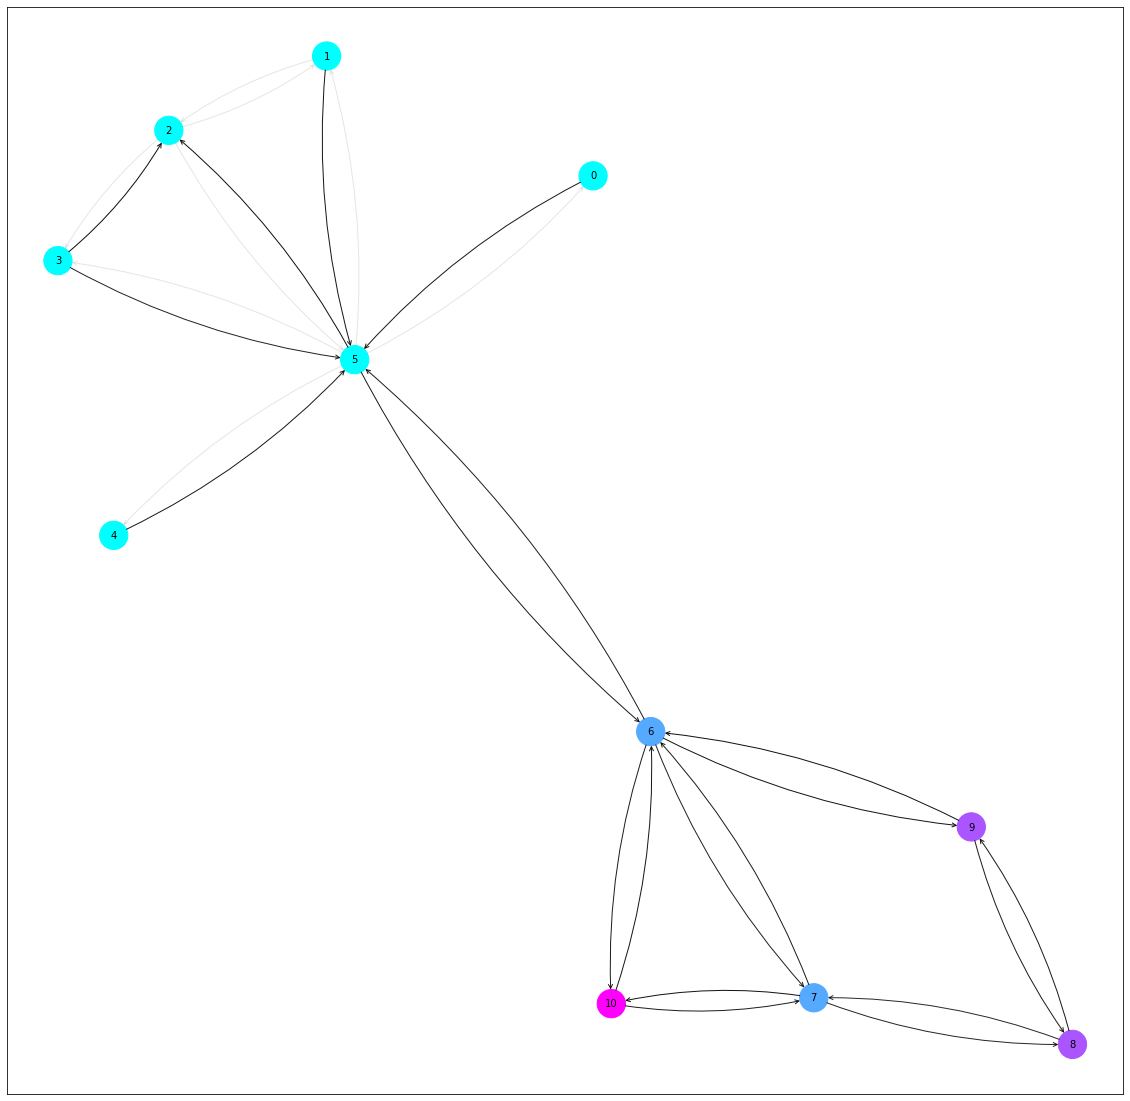

In [12]:
plt.figure(figsize=(20, 20))
print(f"We wanna explain node: {node_idx_hop_subgraph.item()}.")
node_feat_mask, edge_mask = explainer.explain_node(
    node_idx_hop_subgraph, subgraph.x, subgraph.edge_index
)
ax, G = explainer.visualize_subgraph(
    node_idx_hop_subgraph, subgraph.edge_index, edge_mask, y=subgraph.y
)

plt.show()

In [13]:
edge_mask

tensor([0.9019, 0.0788, 0.9110, 0.0573, 0.0783, 0.0528, 0.9461, 0.8601, 0.9031,
        0.0730, 0.0790, 0.9351, 0.0671, 0.0709, 0.8934, 0.8799, 0.8666, 0.9166,
        0.8833, 0.8854, 0.8473, 0.9220, 0.8328, 0.8942, 0.9290, 0.8854, 0.9117,
        0.8786], device='cuda:0')

In [14]:
# Calculate accuracy for each subgraph